---
title: "Testing known repeaters with limited samples"
date: "2023-08-09"

---

# FRB20190915D

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

from astropy.timeseries import LombScargle
from astropy.time import Time

DATAPATH = os.getenv('DATAPATH')
CATALOG_PATH = Path(DATAPATH, 'raw', 'catalog2023', 'catalog2023_profile.parquet')
CATALOG_PATH_CSV = Path(DATAPATH, 'raw', 'catalog2023', 'chimefrb2023repeaters.csv')
CATALOG1_PATH_PARQUET = Path(DATAPATH, 'catalog_1.parquet')

cat1 = pd.read_parquet(CATALOG1_PATH_PARQUET)[["eventname","repeater_name", "mjd_400", "fluence"]]
cat1['catalog'] = 'Catalog 1'
cat2023 = pd.read_csv(CATALOG_PATH_CSV)[["tns_name","repeater_name","mjd_400", "fluence"]].rename(columns={'tns_name':'eventname'})
cat2023['catalog'] = 'Catalog 2023'
data = pd.concat([cat1, cat2023])
data['mjd'] = data['mjd_400']
data

,eventname,repeater_name,mjd_400,fluence,catalog,mjd
0,FRB20180725A,-9999,58324.749803,4.00,Catalog 1,58324.749803
1,FRB20180727A,-9999,58326.036262,2.30,Catalog 1,58326.036262
2,FRB20180729A,-9999,58328.033565,20.00,Catalog 1,58328.033565
3,FRB20180729B,-9999,58328.728032,1.20,Catalog 1,58328.728032
4,FRB20180730A,-9999,58329.151134,30.00,Catalog 1,58329.151134
...,...,...,...,...,...,...
146,FRB20210313E,FRB20201221B,59286.202113,1.13,Catalog 2023,59286.202113
147,FRB20210331F,FRB20210323C,59304.147737,6.10,Catalog 2023,59304.147737
148,FRB20210331F,FRB20210323C,59304.147737,6.10,Catalog 2023,59304.147737
149,FRB20210426B,FRB20210323C,59330.091835,7.60,Catalog 2023,59330.091835


In [2]:
import seaborn as sns

chosen_name = 'FRB20180916B' # (77)

selected = data[['repeater_name', 'mjd', 'catalog']].sort_values(by='mjd')
selected[chosen_name] = (selected['repeater_name'] == chosen_name).astype(int)
# detections = selected[chosen_name].sum()
selected['datetime'] = Time(selected['mjd'], format='mjd').to_datetime()
to_plot=selected.set_index('datetime').resample('d').sum()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16364\1814019445.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_plot=selected.set_index('datetime').resample('d').sum()


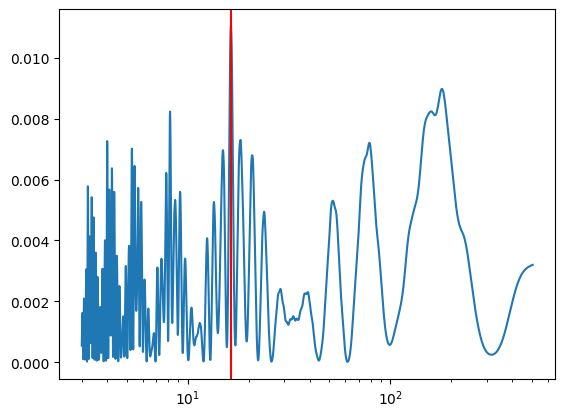

In [3]:
import astropy.units as u

time = Time(to_plot.index.to_numpy())
obs = to_plot[chosen_name].to_numpy()

freq_min = 1 / (3 * u.day)
freq_max = 1/(len(to_plot)*.5 * u.day)

freq_grid = np.linspace(freq_max,freq_min, 10_000)

LS = LombScargle(time, obs)
power = LS.power(freq_grid)

p = 1/freq_grid[np.nanargmax(power)]

g = sns.lineplot(x=1/freq_grid, y=power)
g.axvline(p.value, color='red', alpha=1)
g.set_xscale('log')

In [4]:
1/freq_grid[np.nanargmax(power)]

<Quantity 16.33002105 d>

## Limited Window

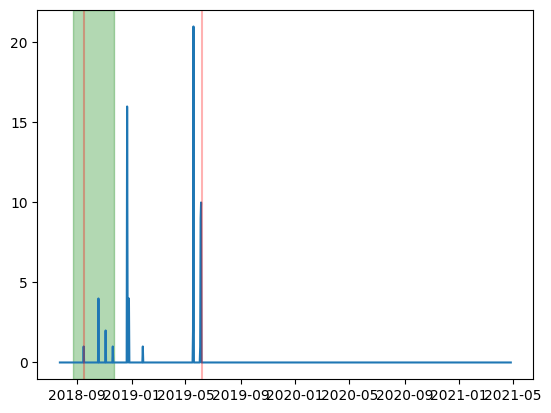

In [5]:
expected = 30
observation = 3*expected
offset = 30

page = 0
window = offset+page*observation
limited = to_plot[window:window+observation]

g = sns.lineplot(x=to_plot.index.to_numpy(), y=to_plot[chosen_name].to_numpy())
g.axvspan(to_plot.index[window], to_plot.index[window+observation], color='green', alpha=0.3)
g.axvline(to_plot.index[-691], color='red', alpha=0.3)
g.axvline(to_plot.index[53], color='red', alpha=0.3)

In [6]:
from copy import deepcopy


def get_first_and_last_index(items: list) -> (int, int):
    first = 0
    last = 0
    for item in deepcopy(items):
        if item == 0:
            first += 1
        elif item > 0:
            break
    for item in deepcopy(items)[::-1]:
        if item == 0:
            last -= 1
        elif item > 0:
            break
    return first, last

get_first_and_last_index(to_plot[chosen_name].to_numpy())

(53, -691)

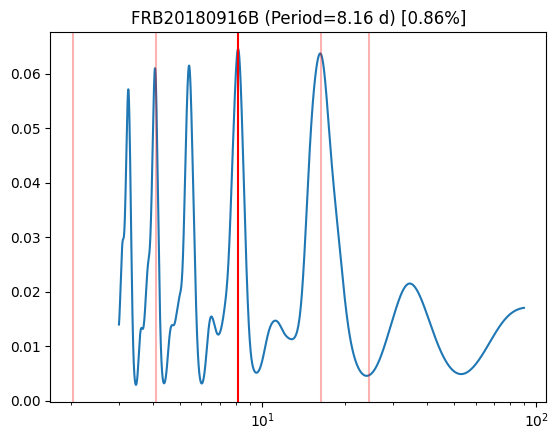

In [7]:
limited_time = Time(limited.index.to_numpy())
limited_obs = limited[chosen_name].to_numpy()

assert np.sum(limited_obs) > 0, "No Observation found"

freq_min = 1 / (3 * u.day)
freq_max = 1/(len(limited) * u.day)

freq_grid = np.linspace(freq_max,freq_min, 10_000)

LS = LombScargle(limited_time, limited_obs)
power = LS.power(freq_grid)

p = 1/freq_grid[np.nanargmax(power)]

false_alarm_prob = LS.false_alarm_probability(1/p)

g = sns.lineplot(x=1/freq_grid, y=power)
g.axvline(p.value, color='red', alpha=1)
g.axvline(2*p.value, color='red', alpha=0.3)
g.axvline(3*p.value, color='red', alpha=0.3)
g.axvline(0.5*p.value, color='red', alpha=0.3)
g.axvline(0.25*p.value, color='red', alpha=0.3)
# g.set_ylim(0,0.003)
g.set_title(f"{chosen_name} (Period={p.value:.2f} d) [{false_alarm_prob:.2f}%]")
g.set_xscale('log')

In [8]:
def get_first_and_last_index(items: list) -> (int, int):
    first = 0
    last = 0
    for item in deepcopy(items):
        if item == 0:
            first += 1
        elif item > 0:
            break
    for item in deepcopy(items)[::-1]:
        if item == 0:
            last -= 1
        elif item > 0:
            break
    return first, last
    
def periodicity_within_window(t: np.array, y: np.array, expected_period: float, multiplier: int, offset: int) -> (float, float):
    window = int(np.ceil(multiplier*expected_period))
    limited_t = Time(t[offset+window:offset+(2*window)])
    limited_y = y[offset+window:offset+(2*window)]

    if np.sum(limited_y) == 0:
        raise ValueError("No Observation found.")

    freq_min = 1 / (3 * u.day)
    freq_max = 1/(len(limited_t) * u.day)

    freq_grid = np.linspace(freq_max,freq_min, 10_000)

    LS = LombScargle(limited_t, limited_y)
    power = LS.power(freq_grid)

    period = 1/freq_grid[np.nanargmax(power)]
    false_alarm_prob = LS.false_alarm_probability(1/period)
    return period, false_alarm_prob

In [9]:
from collections import defaultdict


first, last = get_first_and_last_index(to_plot[chosen_name].to_numpy())
biggest_window = len(to_plot[first:last])
# if window > biggest_window:
#     ...

results = defaultdict()
for multiplier in range(2,30):
    periods = []
    fa_probs = []
    for offset in (offsets:=range(45, biggest_window + first)):
        try:
            p, fa_prob = periodicity_within_window(to_plot.index.to_numpy(), to_plot[chosen_name].to_numpy(), 16, multiplier, offset)
            periods.append(p.value)
            fa_probs.append(fa_prob.value)
        except ValueError:
            pass
            # periods.append(None)
            # fa_probs.append(None)
    try:
        results[multiplier] = np.median(periods), np.std(periods), np.mean(periods), np.min(periods), np.max(periods)
    except ValueError:
        pass


d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


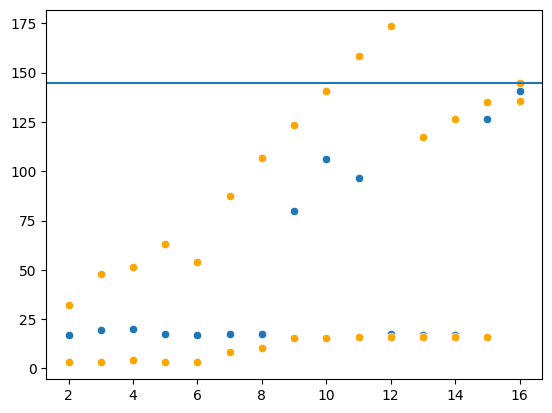

In [10]:
medians = [v[0] for k, v in results.items()]
maxi = [v[-1] for k, v in results.items()]
mini = [v[-2] for k, v in results.items()]

g=sns.scatterplot(x=results.keys(), y=medians)
sns.scatterplot(x=results.keys(), y=maxi, color='orange', ax=g)
sns.scatterplot(x=results.keys(), y=mini, color='orange', ax=g)
g.axhline(p.value)

# Leave One Out Estimation

In [11]:
import astropy.units as u
# Estimate error using leave one out resampling

detections = selected.loc[selected[chosen_name] == 1].index

best_periods = []
for idx in detections:
    reduced=selected[selected.index != idx].set_index('datetime').resample('d').sum(numeric_only=True)

    time = Time(reduced.index.to_numpy())
    obs = reduced[chosen_name].to_numpy()

    freq_min = 1 / (3 * u.day)
    freq_max = 1/(len(reduced)*.5 * u.day)

    freq_grid = np.linspace(freq_max,freq_min, 10_000)

    LS = LombScargle(time, obs)
    power = LS.power(freq_grid)

    best_periods.append(1/freq_grid[np.nanargmax(power)].value)

stats_ = pd.DataFrame(np.array(best_periods)).describe().transpose().to_dict(orient='record')[0]
stats_

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16364\1104562449.py:23: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  stats_ = pd.DataFrame(np.array(best_periods)).describe().transpose().to_dict(orient='record')[0]


{'count': 77.0,
 'mean': 16.3305951869346,
 'std': 0.002192978856628187,
 'min': 16.33002105112927,
 '25%': 16.33002105112927,
 '50%': 16.33002105112927,
 '75%': 16.33002105112927,
 'max': 16.338862742531433}

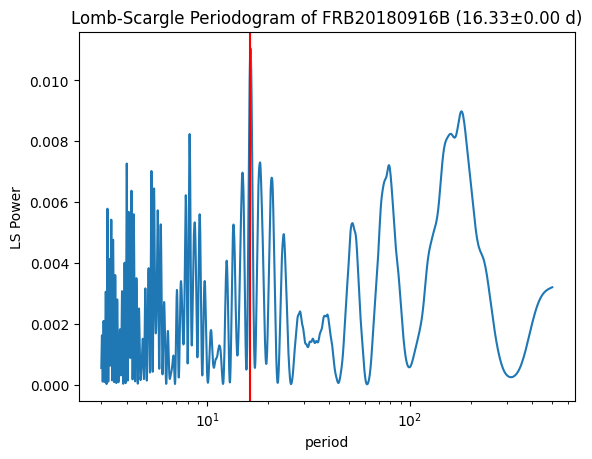

In [12]:
import astropy.units as u

time = Time(to_plot.index.to_numpy())
obs = to_plot[chosen_name].to_numpy()

freq_min = 1 / (3 * u.day)
freq_max = 1/(len(to_plot)*.5 * u.day)

freq_grid = np.linspace(freq_max,freq_min, 10_000)

LS = LombScargle(time, obs)
power = LS.power(freq_grid)

p = 1/freq_grid[np.nanargmax(power)]

low = stats_['mean'] - stats_['std']*2
high = stats_['mean'] + stats_['std']*2

g = sns.lineplot(x=1/freq_grid, y=power)
g.axvline(p.value, color='red', alpha=1)
g.axvspan(low, high, alpha=0.3)
g.set_xscale('log')
g.set_xlabel('period')
g.set_ylabel('LS Power')
g.set_title(f'Lomb-Scargle Periodogram of {chosen_name} ({p.value:.2f}±{2*stats_["std"]:.2f} d)')
g.figure.savefig(f'{chosen_name}-periodogram-LS.png')

In [13]:
low, p.value, high

(16.326209229221345, 16.33002105112927, 16.33498114464786)

# Phase Folding

In [14]:
folded = selected[['mjd', chosen_name]]
folded['datetime'] = Time(folded['mjd'], format='mjd').to_datetime()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16364\1318021332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  folded['datetime'] = Time(folded['mjd'], format='mjd').to_datetime()


In [15]:
folded

,mjd,FRB20180916B,datetime
0,58324.749803,0,2018-07-25 17:59:42.996999
1,58326.036262,0,2018-07-27 00:52:13.000944
2,58328.033565,0,2018-07-29 00:48:19.998573
3,58328.728032,0,2018-07-29 17:28:21.999187
4,58329.151134,0,2018-07-30 03:37:38.000583
...,...,...,...
147,59304.147737,0,2021-03-31 03:32:44.442940
148,59304.147737,0,2021-03-31 03:32:44.451874
139,59310.966072,0,2021-04-06 23:11:08.622372
149,59330.091835,0,2021-04-26 02:12:14.531196


In [16]:
from astropy.timeseries import TimeSeries

reduced = folded.set_index('datetime').resample('d').sum()
t_frb = TimeSeries(time=reduced.index, data={'detections':reduced[chosen_name].to_numpy().reshape(-1,1)})

frac = []
trial_p = 1/freq_grid
for p in trial_p:
    folded_ = t_frb.fold(period=p, wrap_phase=1, normalize_phase=True)
    phases = np.array(folded_['time'])
    counts = np.array(folded_['detections']).flatten()
    phases = pd.DataFrame({'phase':phases, 'detections': counts}).groupby(pd.cut(phases, np.arange(0,1, 0.02)))['detections'].sum()
    phases = phases.reset_index().rename(columns={'index': 'phase_bin'})
    phases['cumsum'] = phases['detections'].cumsum()
    inactive = 0
    state = 0
    prev = 0
    for current in phases['cumsum']:
        if current == prev:
            state += 1
        else:
            prev = current
            inactive = state if state > inactive else inactive
            state = 0
    frac.append(inactive/len(phases))

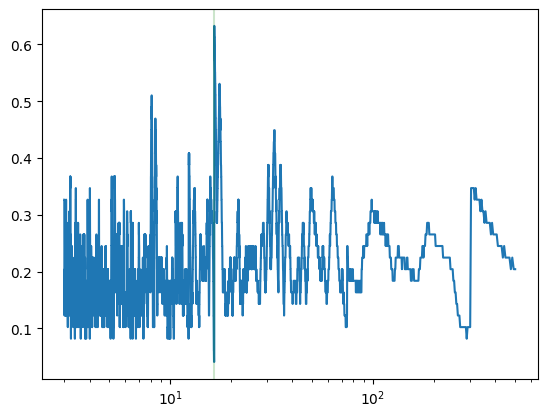

In [17]:
g = sns.lineplot(x=trial_p, y=frac)
g.axvline(trial_p.value[np.nanargmax(frac)], color='green', alpha=0.2)
g.set_xscale('log')

In [18]:
trial_p.value[np.nanargmax(frac)]

16.499666532478535

In [19]:
detections = selected.loc[selected[chosen_name] == 1].index

def calc_inactive_frac(timeseries: TimeSeries, trial_periods: np.ndarray):
    frac = []
    for period in trial_periods:
        folded_ = timeseries.fold(period=period, wrap_phase=1, normalize_phase=True)
        phases = np.array(folded_['time'])
        counts = np.array(folded_['detections']).flatten()
        phases = pd.DataFrame({'phase':phases, 'detections': counts}).groupby(pd.cut(phases, np.arange(0,1, 0.05)))['detections'].sum()
        phases = phases.reset_index().rename(columns={'index': 'phase_bin'})
        phases['cumsum'] = phases['detections'].cumsum()
        inactive = 0
        state = 0
        prev = 0
        for current in phases['cumsum']:
            if current == prev:
                state += 1
            else:
                prev = current
                inactive = state if state > inactive else inactive
                state = 0
        frac.append(inactive/len(phases))
    return frac

best_periods = []
for idx in detections:
    folded = selected.loc[selected.index != idx, ['mjd', chosen_name]]
    folded['datetime'] = Time(folded['mjd'], format='mjd').to_datetime()
    reduced = folded.set_index('datetime').resample('d').sum()
    t_frb = TimeSeries(time=reduced.index, data={'detections':reduced[chosen_name].to_numpy().reshape(-1,1)})
    frac = calc_inactive_frac(t_frb, 1/freq_grid)
    best_periods.append(1/freq_grid[np.nanargmax(frac)].value)

stats = pd.DataFrame(np.array(best_periods)).describe().transpose().to_dict(orient='record')[0]
stats

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16364\4185941778.py:34: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  stats = pd.DataFrame(np.array(best_periods)).describe().transpose().to_dict(orient='record')[0]


{'count': 77.0,
 'mean': 16.61153559592509,
 'std': 0.10664330874314487,
 'min': 16.59037716812769,
 '25%': 16.59950311910634,
 '50%': 16.59950311910634,
 '75%': 16.59950311910634,
 'max': 17.535129785128188}

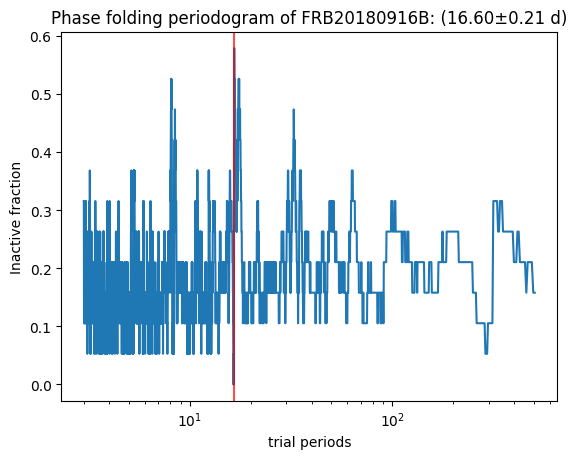

In [20]:
low = stats['mean'] - stats['std']*100
high = stats['mean'] + stats['std']*100

g = sns.lineplot(x=trial_p, y=frac)
g.axvline(period:=trial_p.value[np.nanargmax(frac)], color='red', alpha=0.7)
g.axvline(low, high, alpha=0.3)
g.set_xscale('log')
g.set_xlabel('trial periods')
g.set_ylabel('Inactive fraction')
g.set_title(f'Phase folding periodogram of {chosen_name}: ({period:.2f}±{2*stats["std"]:.2f} d)')
g.figure.savefig(f'{chosen_name}-periodogram-phase.png')

In [23]:
1-np.nanmax(frac)

0.42105263157894735